Implement the **`backpropagation algorithm`** for neural networks and apply it to the task of hand-written digit recognition

In [1]:
import numpy  as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy
import scipy.optimize as opt
import scipy.io as sio
from scipy.io import loadmat

%matplotlib inline

# Neural Network

Implement the backpropagation algorithm to learn the parameters for the neural network.

In [2]:
path = "dataset/ex4data1.mat"
ori_data = sio.loadmat(path)
X_ori = ori_data.get('X')
y_ori = ori_data.get('y').reshape((-1,))
sample = y_ori.shape[0]
print(">> X_ori.shape :", X_ori.shape)
print("   y_ori.shape :", y_ori.shape)
print("   Samples :", sample)
print("   y classes :", np.unique(y_ori))

>> X_ori.shape : (5000, 400)
   y_ori.shape : (5000,)
   Samples : 5000
   y classes : [ 1  2  3  4  5  6  7  8  9 10]


## Visualizing the data

There are 5000 training examples in `ex4data1.mat`, where each training example is `a 20 pixel by 20 pixel grayscale image of the digit`. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix $X$. This gives us a 5000 by 400 matrix $X$ where every row is a training example for a handwritten digit image.

$$ X = \begin{bmatrix} - \left(x^{(1)} \right)^T - \\
- \left(x^{(2)} \right)^T - \\
\vdots \\
- \left(x^{(m)} \right)^T - \\
\end{bmatrix}
$$

###### form data for visualize

In [3]:
def form_data_for_visualize(X, y):
    # for this dataset, you need a transpose to get the orientation right
    X_img = np.array([im.reshape((20, 20)).T for im in X])
    # and I flat the image again to preserve the vector presentation
    X_img = np.array([im.reshape(400) for im in X_img])
    y_img = y
    
    return X_img, y_img

X_img, y_img = form_data_for_visualize(X_ori, y_ori)

###### visualize all data

In [4]:
def visualize_data(X, y):
    img_size = int(np.sqrt(X.shape[1]))
    
    sample_idx = np.sort(np.random.choice(5000, 100))
    sample_img = X[sample_idx, :]
    
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))
    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_img[10 * r + c].reshape((img_size, img_size)),
                                   cmap=mpl.cm.binary) # Greys_r
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

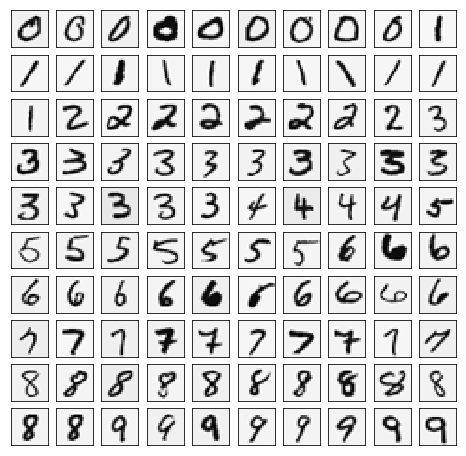

In [5]:
visualize_data(X_img, y_img)

###### visualize one image

In [6]:
def visualize_one_image(image, method=0):
    fig, ax = plt.subplots(figsize=(1, 1))
    if method == 0:
        ax.matshow(image.reshape((20, 20)), cmap=mpl.cm.binary)
    elif method == 1:
        plt.imshow(image.reshape((20, 20)), cmap=mpl.cm.binary)
    plt.xticks(np.array([]))  # just get rid of ticks
    plt.yticks(np.array([]))

this should be 7


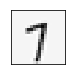

In [7]:
#pick_one = np.random.choice(5000, 1)
pick_one = np.random.randint(0, 5000)
visualize_one_image(X_img[pick_one, :])
print('this should be {}'.format(y_img[pick_one]))

###### visualize all classes data

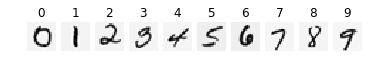

In [8]:
y_one_class = y_ori.copy()
y_one_class[y_one_class == 10] = 0

classes = np.arange(0, 10)
num_classes = len(classes)
sample_each_class = 1

for y, cla in enumerate(classes):
    idxs = np.array(np.where(y_one_class == y)).reshape((-1,))
    idxs = np.random.choice(idxs, sample_each_class, replace=False)

    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(sample_each_class, num_classes, plt_idx)
        plt.imshow(X_img[idx].reshape((20, 20)), cmap=mpl.cm.binary)
        plt.axis('off')
        if i == 0:
            plt.title(cla)

##### form training data

In [9]:
def form_train_data(X_ori, y_ori, K):
    X_train = X_ori.T
    
    # transform vector-y to one-hot
    y_matrix = []
    for k in range(1, K+1):
        y_matrix.append((y_ori == k).astype(int))
    y_train = np.array(y_matrix)
    
    print("X_train.shape :", X_train.shape)
    print("y_train.shape :", y_train.shape)
    
    return X_train, y_train

X_train, y_train = form_train_data(X_ori, y_ori, K=10)
theta_init_zero = np.zeros((X_train.shape[1],))

X_train.shape : (400, 5000)
y_train.shape : (10, 5000)


## Model Representation

![](Figures/neural_network.png)

###### load trainned weights

In [10]:
def load_weight(path):
    weights = sio.loadmat(path)
    print('weights[\'Theta1\'].shape', weights['Theta1'].shape)
    print('weights[\'Theta2\'].shape', weights['Theta2'].shape)
    shape_1 = weights['Theta1'].shape
    shape_2 = weights['Theta2'].shape
    shape = (shape_1[1]-1, shape_1[0], shape_2[0])
    
    return weights['Theta1'], weights['Theta2'], shape

In [11]:
weights_path = "dataset/ex4weights.mat"
theta1, theta2, nn_shape = load_weight(weights_path)
theta_all = np.array([theta1, theta2])

weights['Theta1'].shape (25, 401)
weights['Theta2'].shape (10, 26)


###### proccess theta function

In [12]:
def flatten_theta(theta):
    theta_f_all = []
    for theta_i in theta:
        theta_f = theta_i.flatten().reshape((-1,))
        theta_f_all = np.r_[ theta_f_all, theta_f ]

    return theta_f_all

theta_flatten = flatten_theta(theta_all)
theta_flatten.shape

(10285,)

In [13]:
def unflatten_theta(theta, shape):
    theta_all = []
    sum_theta = 0
    for i in np.arange(len(shape)-1):
        num = shape[i+1] * (shape[i]+1)
        theta_i = theta[sum_theta : sum_theta+num].reshape((shape[i+1], shape[i]+1))
        theta_all.append(np.array(theta_i))
        sum_theta = num + sum_theta
        
    return np.array(theta_all)

theta_unflatten = unflatten_theta(theta_flatten, nn_shape)

## feedforward

In [14]:
def sigmoid(Z):
    return scipy.special.expit(Z)

In [15]:
def feed_forward(theta, X, shape):
    theta_unf = unflatten_theta(theta, shape)
    
    z_bias = np.insert(X, 0, 1, axis=0)
    a1 = z_bias
    
    z2 = theta_unf[0] @ a1
    a2 = np.insert(sigmoid(z2), 0, 1, axis=0)
    
    z3 = theta_unf[1] @ a2
    a3 = sigmoid(z3)
    
    return a1, z2, a2, z3, a3

In [16]:
a1, z2, a2, z3, a3 = feed_forward(theta_flatten, X_train, nn_shape)

## cost function

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$

`Also, recall that whereas the original labels (in the variable y) were 0, 1, ..., 9`, for the purpose of training a neural network, **we need to encode the labels as vectors containing only values 0 or 1, so that**

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and sum the cost over all examples. **Your code should also work for a dataset of any size, with any number of labels** (you can assume that there are always at least $K \ge 3$ labels).

**`Note that you should not be regularizing the terms that correspond to the bias`**`.

In [17]:
num_loop = 0
def cost_function(theta_flatten, X, y, shape, lamd=0, pri=False):
    global num_loop
    print("Num_loop :", num_loop)
    num_loop = num_loop + 1
    a1, z2, a2, z3, a3 = feed_forward(theta_flatten, X, shape)
    m = y.shape[1]
    y_1 = np.log(a3) * y
    y_0 = np.log(1-a3) * (1-y)
    
    cost = -np.mean(np.sum(y_1 + y_0, axis=0))
    theta_unf = unflatten_theta(theta_flatten, shape)
    
    reg_theta = [ np.sum(np.power(reg[:,1:],2)) for reg in theta_unf ]
    reg_item = lamd * np.sum(reg_theta) / (2 * m)

    cost_reg = cost + reg_item

    return cost_reg

In [18]:
cost = cost_function(theta_flatten, X_train, y_train, nn_shape, lamd=0)

Num_loop : 0


In [19]:
cost

0.2876291651613189

In [20]:
cost = cost_function(theta_flatten, X_train, y_train, nn_shape, lamd=1)

Num_loop : 1


In [21]:
cost

0.38376985909092365

# Backpropagation

Implement the backpropagation algorithm to compute the gradient for the neural network cost function

**`Sigmoid Gradient`**

The gradient for the sigmoid function can be
computed as

$$ g'(z) = \frac{d}{dz} g(z) = g(z)\left(1-g(z)\right) $$

where

$$ \text{sigmoid}(z) = g(z) = \frac{1}{1 + e^{-z}} $$

In [22]:
def sigmoid_grad(z):
    sig = sigmoid(z)
    sig_grad = sig * (1 - sig)
    
    return sig_grad

**`Backpropagation Intuition`**

![](Figures/ex4-backpropagation.png)

> `the intuition behind the backpropagation algorithm`
> + Given a training example $(x^{(t)}, y^{(t)})$, we will first run **a “forward pass” to compute all the activations throughout the network**, including the output value of the hypothesis $h_\theta(x)$.
> + Then, for each node $j$ in layer $l$, we would like to compute **an “error term” $\delta_j^{(l)}$ that measures how much that node was “responsible” for any errors in our output**.

1. Set the input layer’s values $(a^{(1)})$ to the $t^{th }$training example $x^{(t)}$. Perform a feedforward pass, computing the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. `Note that you need to add a `+1` term to ensure that the vectors of activations for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit`. 


2. For each output unit $k$ in layer 3 (the output layer), set 
$$\delta_k^{(3)} = \left(a_k^{(3)} - y_k \right)$$
where $y_k \in \{0, 1\}$ indicates whether the current training example belongs to class $k$ $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$.


3. For the hidden layer $l = 2$, set 
$$ \delta^{(2)} = \left( \Theta^{(2)} \right)^T \delta^{(3)} * g'\left(z^{(2)} \right)$$


4. Accumulate the gradient from this example using the following formula. **Note that you should skip or remove $\delta_0^{(2)}$**.


5. Obtain the (unregularized) gradient for the neural network cost function by dividing the accumulated gradients by $\frac{1}{m}$:
$$ \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)}$$

**`Regularized Neural Network`**

$$ \begin{align} 
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} & \qquad \text{for } j = 0 \\
& \frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = D_{ij}^{(l)} = \frac{1}{m} \Delta_{ij}^{(l)} + \frac{\lambda}{m} \Theta_{ij}^{(l)} & \qquad \text{for } j \ge 1
\end{align}
$$

Note that you should *not* be regularizing the first column of $\Theta^{(l)}$ which is used for the bias term. Furthermore, in the parameters $\Theta_{ij}^{(l)}$, $i$ is indexed starting from 1, and $j$ is indexed starting from 0. Thus, 

$$
\Theta^{(l)} = \begin{bmatrix}
\Theta_{1,0}^{(i)} & \Theta_{1,1}^{(l)} & \cdots \\
\Theta_{2,0}^{(i)} & \Theta_{2,1}^{(l)} & \cdots \\
\vdots &  ~ & \ddots
\end{bmatrix}
$$

In [23]:
def back_propagation(theta_flatten, X, y, shape, lamd=0, pri=True):
    m = y.shape[1]
    
    theta_unf = unflatten_theta(theta_flatten, shape)
    t1 = theta_unf[0]
    t2 = theta_unf[1]
    
    delta1 = np.zeros(t1.shape)
    delta2 = np.zeros(t2.shape)
    
    a1, z2, a2, z3, a3 = feed_forward(theta_flatten, X, shape)
    
    err3 = a3 - y

    z2_bias = np.insert(z2, 0, 1, axis=0)
    err2 = (t2.T @ err3) * sigmoid_grad(z2_bias)
    
    t1[:,0] = 0
    t2[:,0] = 0
    reg_item_delta2 = lamd * t2 / m
    reg_item_delta1 = lamd * t1 / m
    
    delta2 = (err3 @ a2.T) / m
    delta1 = (err2[1:] @ a1.T) / m
    
    reg_delta2 = delta2 + reg_item_delta2
    reg_delta1 = delta1 + reg_item_delta1
    
    
    return flatten_theta([reg_delta1, reg_delta2])

In [24]:
grad = back_propagation(theta_flatten, X_train, y_train, nn_shape, lamd=1)

## gradient check

Suppose you have a function $f_i(\theta)$ that purportedly computes $\frac{\partial}{\partial \theta_i} J(\theta)$; you’d like to check if $f_i$ is outputting correct derivative values.

$$
\text{Let } \theta^{(i+)} = \theta + \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
\quad \text{and} \quad \theta^{(i-)} = \theta - \begin{bmatrix} 0 \\ 0 \\ \vdots \\ \epsilon \\ \vdots \\ 0 \end{bmatrix}
$$

So, $\theta^{(i+)}$ is the same as $\theta$, except its $i^{th}$ element has been incremented by $\epsilon$. Similarly, $\theta^{(i−)}$ is the corresponding vector with the $i^{th}$ element decreased by $\epsilon$. You can now numerically verify $f_i(\theta)$’s correctness by checking, for each $i$, that:

$$ f_i\left( \theta \right) \approx \frac{J\left( \theta^{(i+)}\right) - J\left( \theta^{(i-)} \right)}{2\epsilon} $$


<div class="alert alert-box alert-success">
**Practical Tip**: When performing gradient checking, **it is much more efficient to use a small neural network with a relatively small number of input units and hidden units**, thus having a relatively small number
of parameters. Each dimension of $\theta$ requires two evaluations of the cost function and this can be expensive. In the function `checkNNGradients`, our code creates a small random model and dataset which is used with `computeNumericalGradient` for gradient checking. Furthermore, after you are confident that your gradient computations are correct, you should turn off gradient checking before running your learning algorithm.
</div>

**`Gradient check Complex`**

In [25]:
def gradient_check_all_neural(theta_flatten, X, y, shape, lamd=0, epsilon=0.0001):
    grad_all_f = back_propagation(theta_flatten, X, y, shape, lamd)
    
    theta_unf = unflatten_theta(theta_flatten, shape)
    
    theta_t = theta_flatten.reshape((1,-1))
    theta_matrix = np.ones_like(theta_t).T @ theta_t
    epsilon_matrix = np.identity(theta_matrix.shape[0]) * epsilon
    
    theta_plus  = theta_matrix + epsilon_matrix
    theta_minus = theta_matrix - epsilon_matrix
    
    numeric_grad = []
    for (theta_p, theta_m) in zip(theta_plus, theta_minus):
        cost_plus = cost_function(theta_p, X, y, shape, lamd)
        cost_minus = cost_function(theta_m, X, y, shape, lamd)
        diff = (cost_plus - cost_minus) / (2 * epsilon)
        numeric_grad.append(diff)
    
    numeric_grad = np.array(numeric_grad)
    
    diff = np.linalg.norm(numeric_grad - grad_all_f) / np.linalg.norm(numeric_grad + grad_all_f)
    print(diff)

In [26]:
if False:
    gradient_check_all_neural(theta_flatten, X_train, y_train, nn_shape)

**`Gradient check Simple`**

In [27]:
def debugInitializeWeights(fan_out, fan_in):
    # Initialize W using "sin". This ensures that W is always of the same values and will be
    # useful for debugging
    W = np.sin(np.arange(1, 1 + (1+fan_in)*fan_out))/10.0
    W = W.reshape(fan_out, 1+fan_in, order='F')
    return W

In [28]:
def compute_numerical_gradient(J, theta, e=1e-4):
    numgrad = np.zeros(theta.shape)
    perturb = np.diag(e * np.ones(theta.shape))
    for i in range(theta.size):
        loss1 = J(theta - perturb[:, i])
        loss2 = J(theta + perturb[:, i])
        numgrad[i] = (loss2 - loss1)/(2*e)
    return numgrad

In [29]:
def gradient_check_0(lamd=0.0):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    nn_shape = (input_layer_size, hidden_layer_size, num_labels)

    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)

    # Reusing debugInitializeWeights to generate X
    X = debugInitializeWeights(m, input_layer_size - 1)
    y = np.arange(1, 1+m) % num_labels
    X, y = form_train_data(X, y, K=num_labels)   
    
    # Unroll parameters
    nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])
    
    # short hand for cost function
    costFunc = lambda p: cost_function(p, X, y, nn_shape, lamd=lamd)
    numgrad = compute_numerical_gradient(costFunc, nn_params)

    grad = back_propagation(nn_params, X, y, nn_shape, lamd=lamd)
    
    # Visually examine the two gradient computations.The two columns you get should be very similar.
    print("\n\n\tNumgrad\t\tGrad")
    print(np.stack([numgrad, grad], axis=1))
    print('The above two columns you get should be very similar.')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)\n')

    # Evaluate the norm of the difference between two the solutions. If you have a correct
    # implementation, and assuming you used e = 0.0001 in computeNumericalGradient, then diff
    # should be less than 1e-9.
    diff = np.linalg.norm(numgrad - grad)/np.linalg.norm(numgrad + grad)

    print('If your backpropagation implementation is correct, then \n'
          'the relative difference will be small (less than 1e-9). \n\n'
          '>>> Relative Difference: %g' % diff)

In [30]:
gradient_check_0(0)

X_train.shape : (3, 5)
y_train.shape : (3, 5)
Num_loop : 2
Num_loop : 3
Num_loop : 4
Num_loop : 5
Num_loop : 6
Num_loop : 7
Num_loop : 8
Num_loop : 9
Num_loop : 10
Num_loop : 11
Num_loop : 12
Num_loop : 13
Num_loop : 14
Num_loop : 15
Num_loop : 16
Num_loop : 17
Num_loop : 18
Num_loop : 19
Num_loop : 20
Num_loop : 21
Num_loop : 22
Num_loop : 23
Num_loop : 24
Num_loop : 25
Num_loop : 26
Num_loop : 27
Num_loop : 28
Num_loop : 29
Num_loop : 30
Num_loop : 31
Num_loop : 32
Num_loop : 33
Num_loop : 34
Num_loop : 35
Num_loop : 36
Num_loop : 37
Num_loop : 38
Num_loop : 39
Num_loop : 40
Num_loop : 41
Num_loop : 42
Num_loop : 43
Num_loop : 44
Num_loop : 45
Num_loop : 46
Num_loop : 47
Num_loop : 48
Num_loop : 49
Num_loop : 50
Num_loop : 51
Num_loop : 52
Num_loop : 53
Num_loop : 54
Num_loop : 55
Num_loop : 56
Num_loop : 57
Num_loop : 58
Num_loop : 59
Num_loop : 60
Num_loop : 61
Num_loop : 62
Num_loop : 63
Num_loop : 64
Num_loop : 65
Num_loop : 66
Num_loop : 67
Num_loop : 68
Num_loop : 69
Num_loop :

## training model

**`Random Initialization`**

One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network. A good choice of $\epsilon_{init}$ is $\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$ where $L_{in} = s_l$ and $L_{out} = s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{l}$.

In [31]:
def build_theta(size):
    z = np.random.uniform(-0.12, 0.12, size)
    return z

init_theta = build_theta(10285)

In [32]:
def nn_train(theta, X, y, loop=10):
    res = opt.minimize(
        fun = cost_function,
        x0 = init_theta,
        args = (X, y, nn_shape),
        method = "BFGS",
        jac = back_propagation,
        options = {"maxiter":loop}
    )
    return res

In [33]:
Loop = 100
res = nn_train(init_theta, X_train, y_train, loop=Loop)
print(res)

Num_loop : 78
Num_loop : 79
Num_loop : 80
Num_loop : 81
Num_loop : 82
Num_loop : 83
Num_loop : 84
Num_loop : 85
Num_loop : 86
Num_loop : 87
Num_loop : 88
Num_loop : 89
Num_loop : 90
Num_loop : 91
Num_loop : 92
Num_loop : 93
Num_loop : 94
Num_loop : 95
Num_loop : 96
Num_loop : 97
Num_loop : 98
Num_loop : 99
Num_loop : 100
Num_loop : 101
Num_loop : 102
Num_loop : 103
Num_loop : 104
Num_loop : 105
Num_loop : 106
Num_loop : 107
Num_loop : 108
Num_loop : 109
Num_loop : 110
Num_loop : 111
Num_loop : 112
Num_loop : 113
Num_loop : 114
Num_loop : 115
Num_loop : 116
Num_loop : 117
Num_loop : 118
Num_loop : 119
Num_loop : 120
Num_loop : 121
Num_loop : 122
Num_loop : 123
Num_loop : 124
Num_loop : 125
Num_loop : 126
Num_loop : 127
Num_loop : 128
Num_loop : 129
Num_loop : 130
Num_loop : 131
Num_loop : 132
Num_loop : 133
Num_loop : 134
Num_loop : 135
Num_loop : 136
Num_loop : 137
Num_loop : 138
Num_loop : 139
Num_loop : 140
Num_loop : 141
Num_loop : 142
Num_loop : 143
Num_loop : 144
Num_loop : 145
Nu

## accuracy

If your implementation is correct, you should see a reported training accuracy of about **95.3%**.

In [34]:
if Loop >= 100:
    theta = res.x
else:
    theta_flatten = flatten_theta(theta_all)
    theta = theta_flatten

a1, z2, a2, z3, a3 = feed_forward(theta, X_train, nn_shape)
y_pred = np.argmax(a3, axis=0) + 1

In [35]:
corret = [1 if a == b else 0 for (a,b) in zip (y_ori, y_pred)]
accu   = sum(map(int, corret)) / float(len(corret))
print('Accuracy = {0}%'.format(accu * 100))

Accuracy = 97.5%


In [36]:
accu   = np.mean(y_pred == y_ori)
print('Accuracy = {0}%'.format(accu * 100))

Accuracy = 97.5%


In [37]:
from sklearn.metrics import classification_report

def accuary(theta_flatten, X, y):
    a1, z2, a2, z3, a3 = feed_forward(theta_flatten, X, nn_shape)
    y_pred = np.argmax(a3, axis=0) + 1
    print(classification_report(y, y_pred))

if Loop >= 100:
    theta = res.x
else:
    theta_flatten = flatten_theta(theta_all)
    theta = theta_flatten
accuary(theta, X_train, y_ori)

             precision    recall  f1-score   support

          1       0.99      0.98      0.99       500
          2       0.97      0.97      0.97       500
          3       0.96      0.96      0.96       500
          4       0.97      0.98      0.97       500
          5       0.96      0.97      0.97       500
          6       0.99      0.98      0.98       500
          7       0.98      0.98      0.98       500
          8       0.97      0.98      0.97       500
          9       0.97      0.97      0.97       500
         10       0.99      0.98      0.98       500

avg / total       0.98      0.97      0.98      5000



## show hidden layer

Informally, given a particular hidden unit, one way to visualize what it computes is to find an input $x$ that will cause it to activate (that is, to have an activation value ($a_i^{(l)}$) close to 1). For the neural network you trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit.

Thus, one way to visualize the “representation” captured by the hidden unit is to reshape this 400 dimensional vector into a 20 × 20 image and display it (It turns out that this is equivalent to finding the input that gives the highest activation for the hidden unit, given a “norm” constraint on the input (i.e., $||x||_2 \le 1$)).

(25, 401)


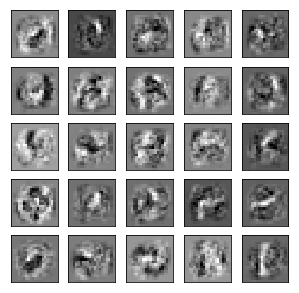

In [38]:
def plot_hidden_layer(theta):
    t1, t2 = unflatten_theta(theta, nn_shape)
    print(t1.shape)
    hidden = t1[:,1:]

    fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(5, 5))
    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(hidden[5 * r + c].reshape((20, 20)),
                                   cmap=mpl.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
            
plot_hidden_layer(theta_flatten)